# Basic image manipulation 

In [3]:
import numpy as np
import matplotlib.pyplot as plt

In [4]:
def plot_image(im, h=5, **kwargs):
    '''
    Helper function to plot an image.
    im: np.array
    '''
    x, y = im.shape[:2]
    w = (y/x)*h
    plt.figure(figsize=(w,h))
    plt.imshow(im, interpolation="none", **kwargs)

In [5]:
im = np.random.randint(low=0, high=255, size=(6000, 6000, 3))
print(im)

[[[185  52 233]
  [101 221 123]
  [226 132 195]
  ...
  [217 201 116]
  [246  28 244]
  [ 42  83 171]]

 [[229 245 135]
  [ 49 201 200]
  [ 18 137  89]
  ...
  [235 147 180]
  [127 118  81]
  [ 12 237 102]]

 [[195 160  86]
  [165  74  50]
  [130 237 232]
  ...
  [141 207  99]
  [ 92 162 204]
  [ 98  62  17]]

 ...

 [[178 183  25]
  [199 170  23]
  [ 80 125 115]
  ...
  [198 141  97]
  [129  80 109]
  [100 214  38]]

 [[175 111 119]
  [ 30   2 232]
  [254  79 164]
  ...
  [171 154  34]
  [ 13  23 157]
  [154 119 151]]

 [[117 253 145]
  [136  23 215]
  [ 94  67 225]
  ...
  [252 209  23]
  [220  10  90]
  [114  35  40]]]


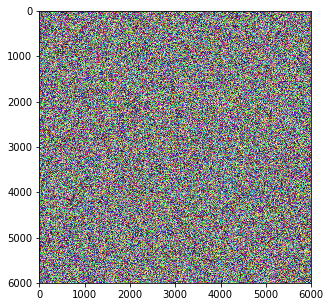

In [6]:
plot_image(im)

In [7]:
mask = np.array([ 
                 [1, 1, 1, 1, 1, 1],
                 [1, 1, 1, 1, 1, 1],
                 [1, 1, 1, 1, 1, 1],
                 [1, 1, 1, 1, 1, 1],
                 [1, 1, 1, 1, 1, 1],
                 [1, 1, 1, 1, 1, 1],
                ])
res = np.sum(im[0:6, 0:6, :]*mask[:,:,np.newaxis], axis=(0,1))
print(res)

[4696 4722 4524]


In [8]:
def apply_mask_once(im, ma, i, j):
    dx, dy = ma.shape
    start_i, end_i = i*dx, (i+1)*dx
    start_j, end_j = j*dy, (j+1)*dy
    indices = (slice(start_i, end_i), slice(start_j, end_j), slice(None, None))
    pixel = np.sum(im[indices]*ma[:, :, np.newaxis], axis=(0, 1))
    return pixel / (ma.size*255)

In [9]:
apply_mask_once(im, mask, 1, 1)

array([0.43082789, 0.51405229, 0.44989107])

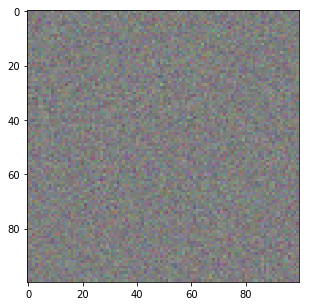

In [11]:
# 6x6
mask = np.ones(shape=(6, 6))
im_comp = np.array([[apply_mask_once(im, mask, i, j) for i in range(0, 100)] for j in range(0, 100)])
plot_image(im_comp)

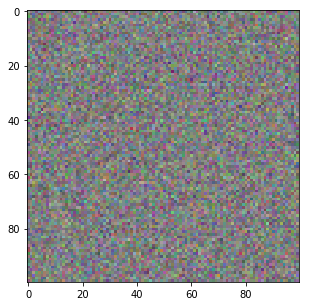

In [12]:
# 3x3
mask = np.ones(shape=(3, 3))
im_comp = np.array([[apply_mask_once(im, mask, i, j) for i in range(0, 100)] for j in range(0, 100)])
plot_image(im_comp)

In [15]:
def method1(image, mask):
    
    # Size of the new image
    dx, dy = mask.shape
    Nx = int(image.shape[0]/dx)
    Ny = int(image.shape[1]/dy)
    
    def reduced_pixel(i, j):
        start_i, end_i = i*dx, (i+1)*dx
        start_j, end_j = j*dy, (j+1)*dy
        indices = (slice(start_i, end_i), slice(start_j, end_j), slice(None, None))
        pixel = np.sum(image[indices]*mask[:, :, np.newaxis], axis=(0, 1))
        return pixel / (mask.size*255)
    
    # Result
    res = np.zeros((Nx, Ny, 3))
    for i in range(0, Nx):
        for j in range(0, Ny):
            res[i, j] = reduced_pixel(i, j)
    
    return res

image = np.random.randint(low=0, high=255, size=(30, 30, 3))
mask = np.ones(shape=(3, 3))
res1 = method1(image, mask)

## Trying with (pseudo) vectorized approach

### Approach with n-dimension mask
Create a mask with the following dimension: `(Nnew, Nold, Nold)`, so one mask per new pixel with a size of the image. But this requires an explicit loop (pseudo-vectorized), and a lot of memory. This is then a very limited approach.

In [156]:
def method2(image, mask):

    # Container for the tranformed mask
    Nx = int(image.shape[0]/mask.shape[0])
    Ny = int(image.shape[1]/mask.shape[1])
    trans_mask = np.zeros((Nx, Ny, *image.shape))

    # Filling the transformed mask
    dx, dy = mask.shape
    for i in np.arange(Nx):
        for j in np.arange(Ny):
            start_i, end_i = i*dx, (i+1)*dx
            start_j, end_j = j*dy, (j+1)*dy
            trans_mask[i, j, start_i:end_i, start_j:end_j, :] = mask[:,:, np.newaxis]
            
    # Perform the computation
    convolution = np.sum(image[np.newaxis, ...]*trans_mask, axis=(2, 3))
    image_res = convolution/(mask.size*255)
    
    return image_res

image = np.random.randint(low=0, high=255, size=(30, 30, 3))
mask = np.ones(shape=(6, 6))
res2 = method2(image, mask)

### Approach with `np.as_strided()`

The idea is to first turn the array of dimensio `(Nx, Ny, Ncolor)` into `(Nx_new, Ny_new, Nx_mask, Ny_mask, Ncol)` and then simply multiply and sum over the axis 2 and 3. In order to do this, the most intuitive approach is to use `np.reshape()` function. It does give the proper shape (by construction) but not the proper data. The other approach is quite advance but also quite powerful: `numpy.lib.stride_tricks.as_strided()`. Strides are basically jump in memory to switch from one element to another. It's not yes all clear but this *doesn't duplicate the data but rather view them as a different way*. This is the approach behind the broadcasting. **This is by far the fastest approach**.

In [157]:
def method2_bis(image, mask):
    '''Taken (and simplified/adapated) from scikit-image/skimage/util/shape.py'''
    
    from numpy.lib.stride_tricks import as_strided

    # Get the new shape
    m_shape, image_shape = np.array(mask.shape), np.array(image.shape)
    new_shape = tuple(image_shape[:2] // m_shape) + tuple(m_shape) + (image_shape[-1],)
    
    # Get the new strides
    new_strides = tuple(image.strides[:2] * m_shape) + image.strides  # --> quesaco ?!
    
    # Get the new blocked image (Nx_new, Ny_new, Nx_mask, Ny_mask, 3)
    blocked_image = as_strided(image, shape=new_shape, strides=new_strides)
    
    # Apply the mask with the proper broadcasting
    mask_reshaped = mask[np.newaxis, np.newaxis, :, :, np.newaxis]
    return np.mean(blocked_image*mask_reshaped, axis=(2, 3), dtype=np.int)
 
image = np.random.randint(low=0, high=255, size=(30, 30, 3))
mask = np.ones(shape=(3, 3))
res2bis = method2_bis(image, mask)

(200, 200, 3)


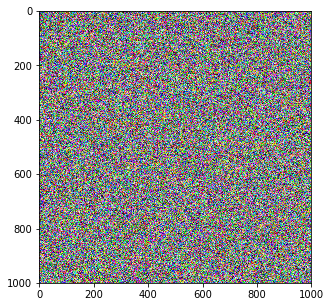

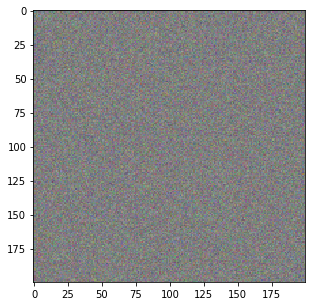

In [158]:
image = np.random.randint(low=0, high=255, size=(1000, 1000, 3))
mask = np.ones(shape=(5, 5))
res2bis = method2_bis(image, mask)
print(res2bis.shape)
plot_image(image)
plot_image(res2bis)

## Using `scipy.convolve2d`

In [69]:
def method3(image, mask):
    from scipy import signal
    
    # Performing 2D convolution
    args = {'in2': mask, 'mode': 'same', 'boundary': 'fill', 'fillvalue': 0}
    res = np.array([signal.convolve2d(image[...,i], **args)/(mask.size*255) for i in np.arange(image.shape[2])])
    
    # Channel (color) is first -> moving it as last axis
    res = np.swapaxes(res, 0, 1)
    res = np.swapaxes(res, 2, 1)

    # Take only one pixel over dx, dy to avoid double counting
    dx, dy = mask.shape
    i0, j0 = dx // 2, dy // 2
    return res[i0::dx, j0::dy, :]

image = np.random.randint(low=0, high=255, size=(30, 30, 3))
mask = np.ones(shape=(6, 6))
res3 = method3(image, mask)

## Using `ndimage` librairy

It was quickly tried but not fully understood. It was not pursuied since the stride approach is anyway the most powerful approach.

## Comparing results

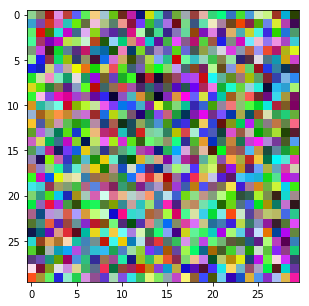

In [155]:
image = np.random.randint(low=0, high=255, size=(30, 30, 3))
mask = np.ones(shape=(5, 5))
plot_image(image)

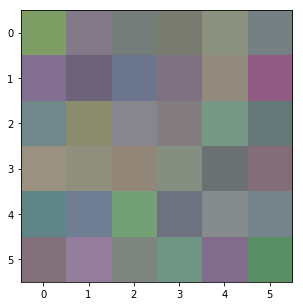

In [133]:
res1 = method1(image, mask)
plot_image(res1)

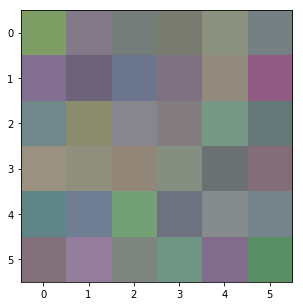

In [134]:
res2 = method2(image, mask)
plot_image(res2)

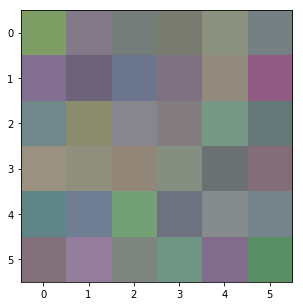

In [135]:
res3 = method3(image, mask)
plot_image(res3)

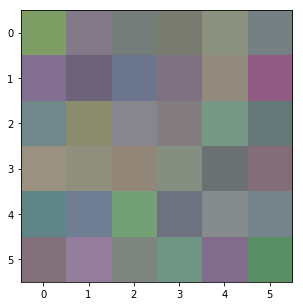

In [136]:
res2bis = method2_bis(image, mask)
plot_image(res2bis)

# Benchmarking

## 100 x 100 = 0.01 Mpixels

In [137]:
image = np.random.randint(low=0, high=255, size=(100, 100, 3))
mask = np.ones(shape=(3, 3))

%timeit method1(image, mask)
%timeit method2(image, mask)
%timeit method2_bis(image, mask)
%timeit method3(image, mask)

17.7 ms ± 342 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
467 ms ± 2.36 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
877 µs ± 13.2 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
1.56 ms ± 23.9 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


## 1000 x 1000 = 1 Mpixels

In [138]:
image = np.random.randint(low=0, high=255, size=(1000, 1000, 3))
mask = np.ones(shape=(3, 3))

%timeit method1(image, mask)
%timeit method2_bis(image, mask)
%timeit method3(image, mask)

1.8 s ± 15.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
96.1 ms ± 2.36 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
225 ms ± 6.59 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


## 6000 x 6000 = 36 Mpixels

In [139]:
image = np.random.randint(low=0, high=255, size=(6000, 6000, 3))
mask = np.ones(shape=(3, 3))
%timeit method2_bis(image, mask)

3.44 s ± 44.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## 1 Mega pixel image but different masks

In [142]:
image = np.random.randint(low=0, high=255, size=(1000, 1000, 3))
m10 = np.ones(shape=(10, 10))
m30 = np.ones(shape=(30, 30))
m100 = np.ones(shape=(100, 100))

%timeit method2_bis(image, m10)
%timeit method2_bis(image, m30)
%timeit method2_bis(image, m100)

58.8 ms ± 152 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
49.4 ms ± 1.29 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
46.1 ms ± 1.48 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


# Test with a real image

In [143]:
test_im = plt.imread('image_test.jpg')
test_im.shape

(3008, 4008, 3)

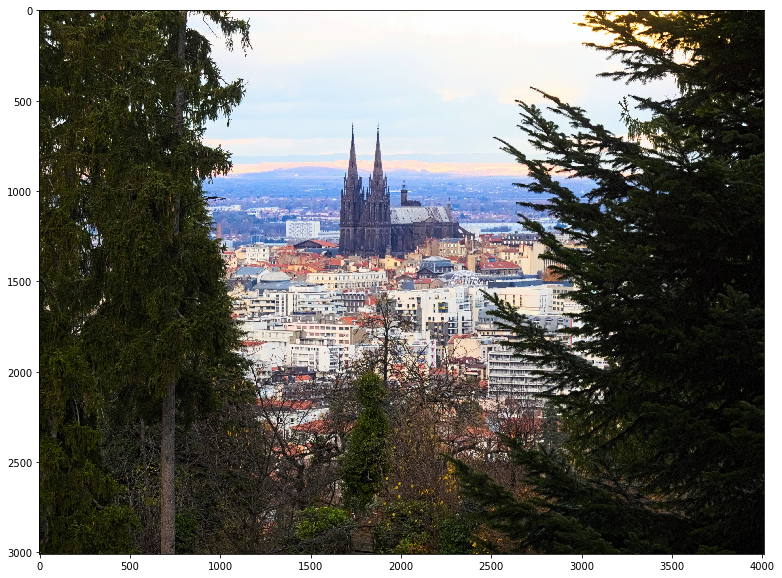

In [145]:
plot_image(test_im, h=10)

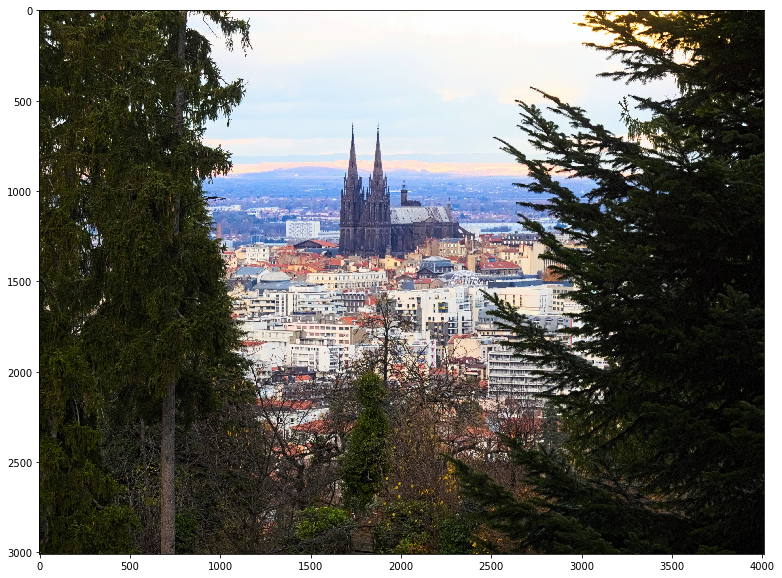

In [150]:
x1, x2, y1, y2 = 600, 1400, 1600, 2400
zoom_img = test_im#[x1:x2, y1:y2]
plot_image(zoom_img, h=10)

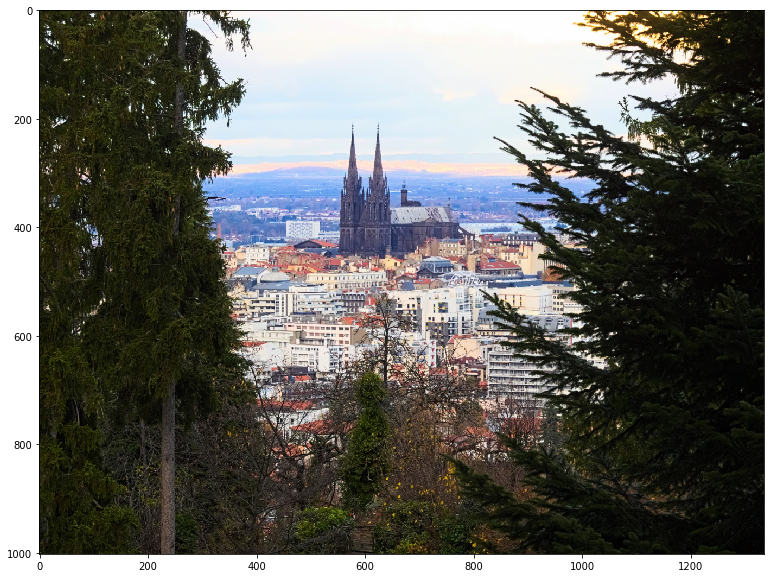

In [151]:
mask = np.ones(shape=(3, 3))
compressed_image = method2_bis(zoom_img, mask)
plot_image(compressed_image, h=10)

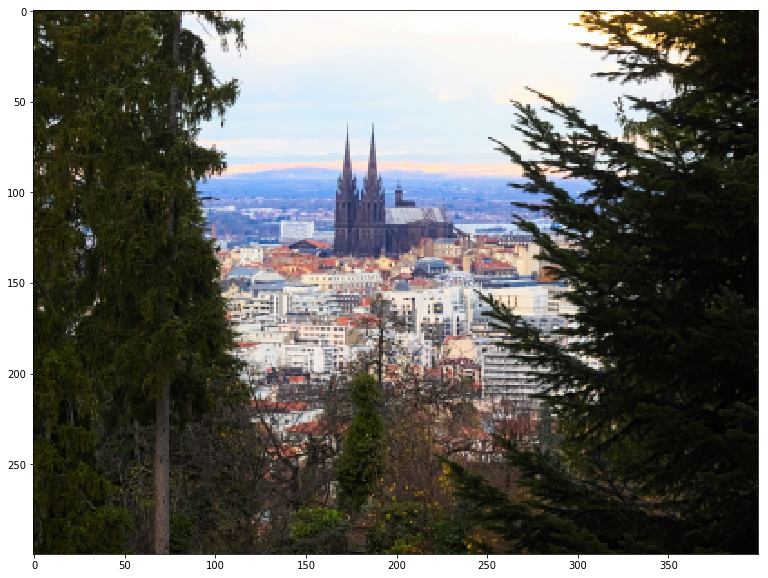

In [152]:
mask = np.ones(shape=(10, 10))
compressed_image = method2_bis(zoom_img, mask)
plot_image(compressed_image, h=10)

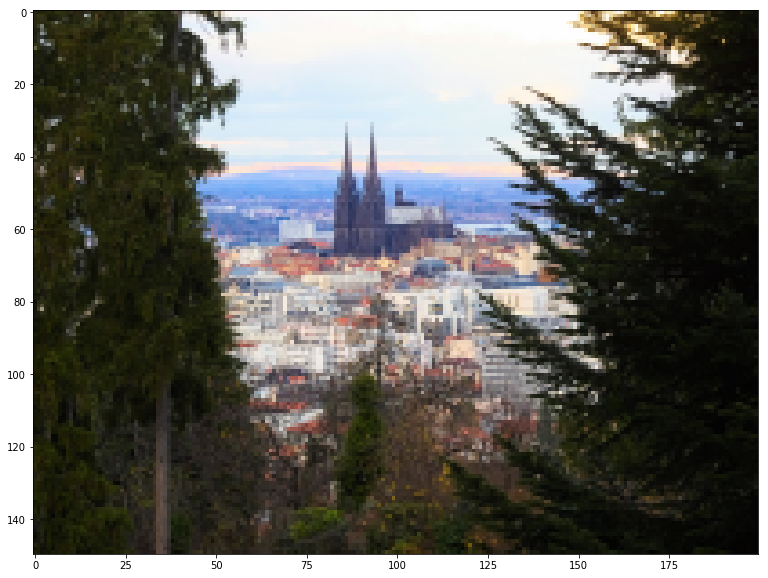

In [153]:
mask = np.ones(shape=(20, 20))
compressed_image = method2_bis(zoom_img, mask)
plot_image(compressed_image, h=10)